In [1]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline

import warnings 

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import MinMaxScaler

from sklearn.cluster import KMeans

from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

from yellowbrick.cluster.elbow import kelbow_visualizer

warnings.filterwarnings("ignore")

In [2]:
portfolio = pd.read_json('portfolio.json', orient='records', lines=True)
profile = pd.read_json('profile.json', orient='records', lines=True)
transcript = pd.read_json('transcript.json', orient='records', lines=True)

# Data Cleaning 

In [3]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [4]:
# check for null values

portfolio.isnull().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

In [5]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [6]:
# create alias for each offer type

new_col = {'offer_name' : ['of_1', 'of_2','of_3','of_4','of_5','of_6','of_7','of_8','of_9','of_10' ]}
portfolio['offer_name'] = pd.DataFrame(new_col)

In [7]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id,offer_name
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,of_1
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,of_2
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,of_3
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,of_4
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,of_5


In [8]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [9]:
# check for null values 

profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [10]:
# check if null values in gender and income are the same records

null_gender = profile[profile['gender'].isnull()]
null_income = profile[profile['income'].isnull()]

In [11]:
np.sum(null_gender['id'] == null_income['id'])

2175

In [12]:
# drop the null values 

profile = profile.dropna(subset=['gender','income'])
profile = profile.reset_index(drop=True)

In [13]:
profile.isnull().sum()

gender              0
age                 0
id                  0
became_member_on    0
income              0
dtype: int64

In [14]:
# parse date col

profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

In [15]:
#Group the Salary ranges
sal_bins = ['<$50K','$(50,000-74,999)','$(75,000-99,999)', '>$100K']

profile['customer_income_range'] = pd.cut(profile['income'], bins=[1, 49999, 74999, 99999, 150000] , 
                                  labels=sal_bins, include_lowest=True)


In [16]:
#Group the age ranges
age_bins = ['18–25', '26-43', '44-56','57-75', '76+']
profile['age_group'] = pd.cut(profile['age'], bins=[18, 26, 44, 57, 76, 101] , 
                                  labels=age_bins, include_lowest=True)



In [17]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [18]:
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [19]:
transcript['offer_id'] =\
transcript['value'].apply(lambda elem: list(elem.values())[0])

In [20]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id,offer_name
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,of_1
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,of_2
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,of_3
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,of_4
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,of_5


In [21]:
profile.head()

,gender,age,id,became_member_on,income,customer_income_range,age_group
0,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,>$100K,44-56
1,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,>$100K,57-75
2,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,"$(50,000-74,999)",57-75
3,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,"$(50,000-74,999)",57-75
4,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,"$(50,000-74,999)",57-75


In [22]:
transcript.head()

,person,event,value,time,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0


# EDA

### profile

#### Gender

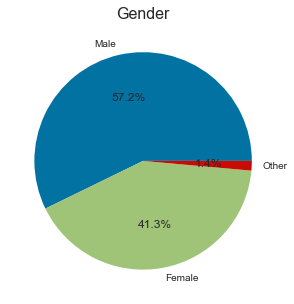

In [23]:
import matplotlib.pyplot as plt

gender_counts = profile['gender'].value_counts()
labels = ['Male', 'Female', 'Other']

plt.figure(figsize=(5, 5))
plt.pie(gender_counts, labels=labels, autopct='%1.1f%%')
plt.title('Gender', fontsize=16)
plt.show()


#### Age Distribution

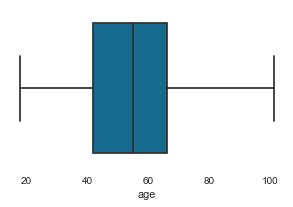

In [24]:
plt.figure(figsize=(5, 3))
sns.boxplot(data = profile, x = 'age')
plt.grid(False)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

#### Age Group Binning

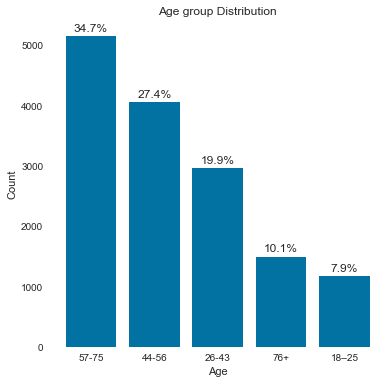

In [25]:
age_group_counts = profile['age_group'].value_counts()

# Calculate the percentage for each gender category
total_count = age_group_counts.sum()
age_percentage = (age_group_counts / total_count) * 100

# Create a bar chart
plt.figure(figsize=(6, 6))
bars = plt.bar(age_group_counts.index, age_group_counts)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age group Distribution')

# Add data labels on top of each bar showing the percentage
for bar, percentage in zip(bars, age_percentage):
    height = bar.get_height()
    plt.annotate(f'{percentage:.1f}%', xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')
plt.grid(False)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()

#### Income Distribution 

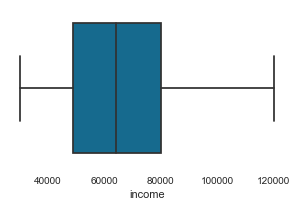

In [26]:
plt.figure(figsize = (5,3))
sns.boxplot(data = profile, x = 'income')
plt.grid(False)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

#### Income range Binning

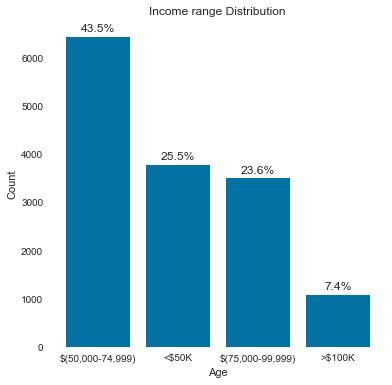

In [27]:
customer_income_range_counts = profile['customer_income_range'].value_counts()

# Calculate the percentage for each gender category
total_count = customer_income_range_counts.sum()
income_percentage = (customer_income_range_counts / total_count) * 100

# Create a bar chart
plt.figure(figsize=(6, 6))
bars = plt.bar(customer_income_range_counts.index, customer_income_range_counts)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Income range Distribution')

# Add data labels on top of each bar showing the percentage
for bar, percentage in zip(bars, income_percentage):
    height = bar.get_height()
    plt.annotate(f'{percentage:.1f}%', xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')
plt.grid(False)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()

#### Extracting Year,Month,Day, Month Name, Day Name, Day Of Week from became_member_on

In [28]:
profile['Year'] = profile['became_member_on'].dt.year
profile['Month'] = profile['became_member_on'].dt.month
profile['Day'] = profile['became_member_on'].dt.day

# Extract month name and day name
profile['Month Name'] = profile['became_member_on'].dt.strftime('%B')
profile['Day Name'] = profile['became_member_on'].dt.strftime('%A')

# Extract the day of the week (Monday: 0, Sunday: 6)
profile['Day of Week'] = profile['became_member_on'].dt.dayofweek

#### Year

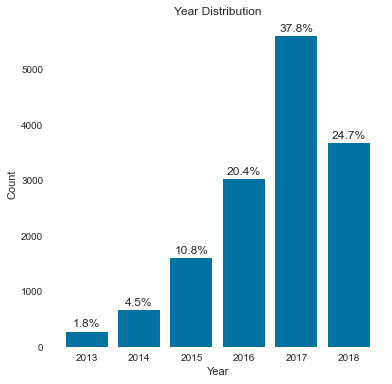

In [29]:
year_counts = profile['Year'].value_counts()

# Calculate the percentage for each gender category
total_count = year_counts.sum()
year_percentage = (year_counts / total_count) * 100

# Create a bar chart
plt.figure(figsize=(6, 6))
bars = plt.bar(year_counts.index, year_counts)
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Year Distribution')

# Add data labels on top of each bar showing the percentage
for bar, percentage in zip(bars, year_percentage):
    height = bar.get_height()
    plt.annotate(f'{percentage:.1f}%', xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')
plt.grid(False)
ax = plt.gca()
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()

#### Month 

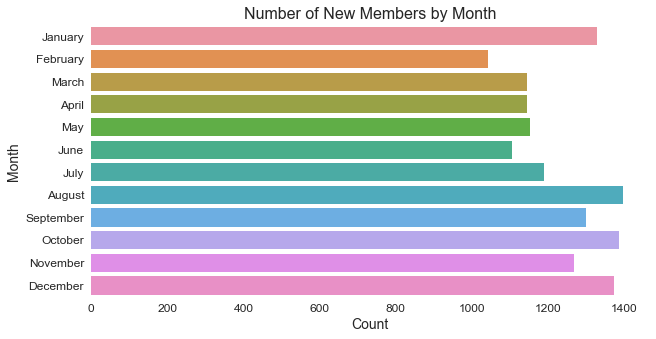

In [30]:
plt.figure(figsize = (10,5))
sns.countplot(data = profile.sort_values('Month'), y = 'Month Name')
plt.title('Number of New Members by Month', fontsize = 16)
plt.xticks(fontsize = 12); plt.yticks(fontsize = 12)
plt.xlabel('Count', fontsize = 14); plt.ylabel('Month', fontsize = 14)
plt.grid(False)

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.show()

#### Week Day

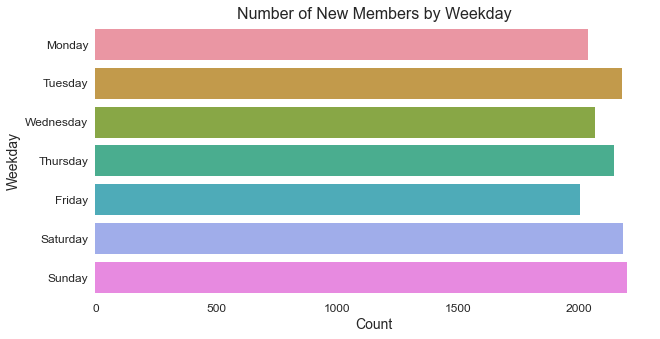

In [31]:
plt.figure(figsize = (10,5))
sns.countplot(data = profile.sort_values('Day of Week'), y = 'Day Name')
plt.title('Number of New Members by Weekday', fontsize = 16)
plt.xticks(fontsize = 12); plt.yticks(fontsize = 12)
plt.xlabel('Count', fontsize = 14); plt.ylabel('Weekday', fontsize = 14)
plt.grid(False)

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()

#### Age vs Gender

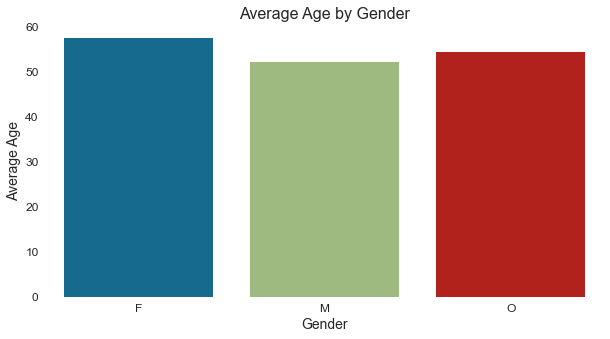

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the average age for each gender
avg_age_by_gender = profile.groupby('gender')['age'].mean()

# Create a bar chart to visualize the average age by gender
plt.figure(figsize=(10, 5))
sns.barplot(x=avg_age_by_gender.index, y=avg_age_by_gender.values)

# Add labels and title
plt.xlabel('Gender', fontsize=14)
plt.ylabel('Average Age', fontsize=14)
plt.title('Average Age by Gender', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(False)

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Show the plot
plt.show()


#### Income by Gender

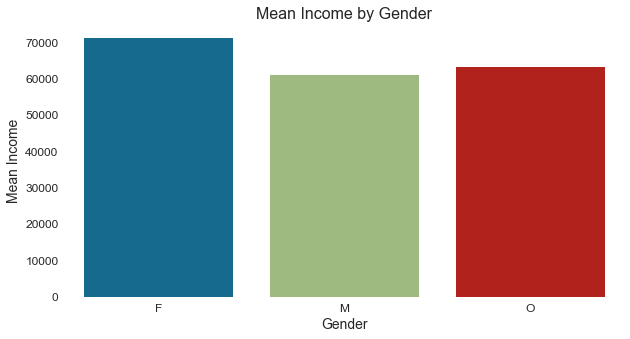

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the mean income for each gender
mean_income_by_gender = profile.groupby('gender')['income'].mean()

# Create a bar chart to visualize the mean income by gender
plt.figure(figsize=(10, 5))
sns.barplot(x=mean_income_by_gender.index, y=mean_income_by_gender.values)

# Add labels and title
plt.xlabel('Gender', fontsize=14)
plt.ylabel('Mean Income', fontsize=14)
plt.title('Mean Income by Gender', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(False)

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Show the plot
plt.show()


#### Income vs Age

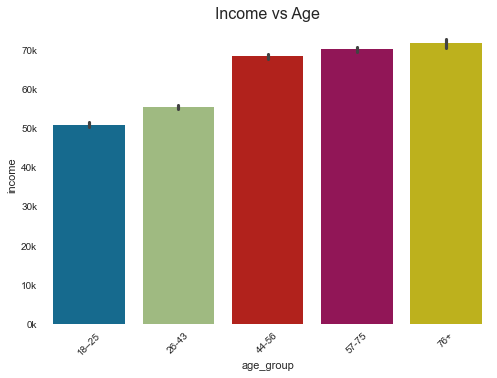

In [34]:
sns.barplot(data = profile, x = 'age_group', y = 'income')
plt.xticks(rotation = 45)
ytick_labels = [str(i) + 'k' for i in (np.arange(0, 80000, 10000) / 1000).astype(int)]
plt.yticks(np.arange(0, 80000, 10000), labels = ytick_labels)
plt.title('Income vs Age', fontsize = 16)

plt.grid(False)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)


plt.show()

## portfolio

#### Offer Type

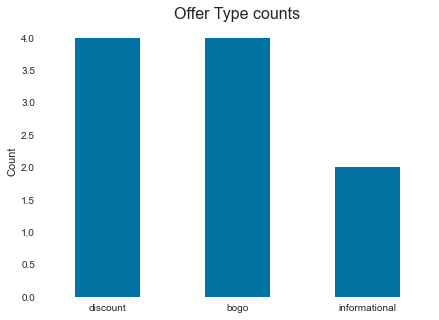

In [35]:
fig = plt.figure(figsize = (7,5))
portfolio['offer_type'].value_counts().plot(kind = 'bar')
plt.xticks(rotation = None)
plt.ylabel('Count')
plt.title('Offer Type counts', fontsize = 16)

plt.grid(False)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()

#### Offer Name

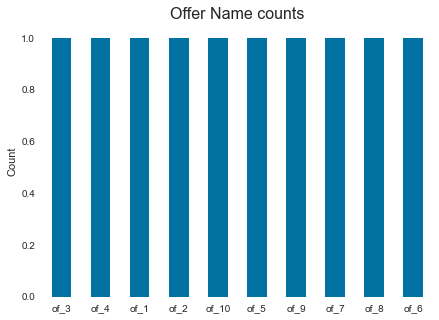

In [36]:
fig = plt.figure(figsize = (7,5))
portfolio['offer_name'].value_counts().plot(kind = 'bar')
plt.xticks(rotation = None)
plt.ylabel('Count')
plt.title('Offer Name counts', fontsize = 16)

plt.grid(False)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()

#### Channels

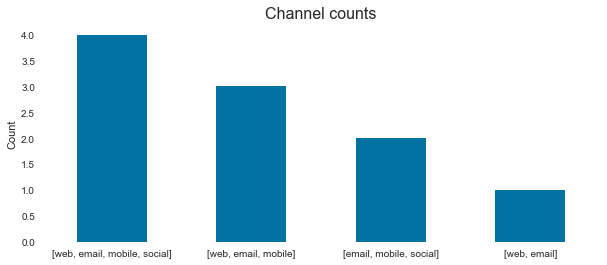

In [37]:
fig = plt.figure(figsize = (10,4))
portfolio['channels'].value_counts().plot(kind = 'bar')
plt.xticks(rotation = None)
plt.ylabel('Count')
plt.title('Channel counts', fontsize = 16)
plt.grid(False)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()

#### Reward

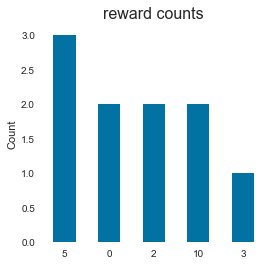

In [38]:
fig = plt.figure(figsize = (4,4))
portfolio['reward'].value_counts().plot(kind = 'bar')
plt.xticks(rotation = None)
plt.ylabel('Count')
plt.title('reward counts', fontsize = 16)
plt.grid(False)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()

#### Difficulty 

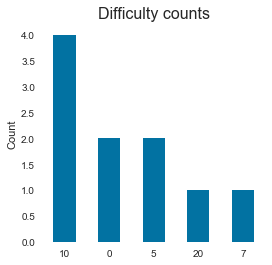

In [39]:
fig = plt.figure(figsize = (4,4))
portfolio['difficulty'].value_counts().plot(kind = 'bar')
plt.xticks(rotation = None)
plt.ylabel('Count')
plt.title('Difficulty counts', fontsize = 16)
plt.grid(False)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()

#### Duration

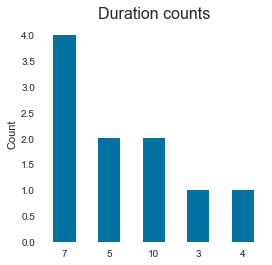

In [40]:
fig = plt.figure(figsize = (4,4))
portfolio['duration'].value_counts().plot(kind = 'bar')
plt.xticks(rotation = None)
plt.ylabel('Count')
plt.title('Duration counts', fontsize = 16)
plt.grid(False)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()

## transcript

#### Event

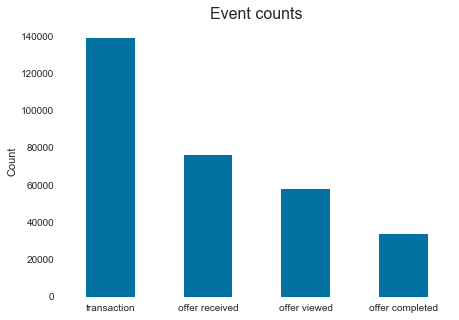

In [41]:
fig = plt.figure(figsize = (7,5))
transcript['event'].value_counts().plot(kind = 'bar')
plt.xticks(rotation = None)
plt.ylabel('Count')
plt.title('Event counts', fontsize = 16)
plt.grid(False)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()

# Data Manipulation

## portfolio

In [42]:
#Rename reward,diificulty,duration,id cols for easier understanding

rename_portfolio = {'difficulty':'offer_difficulty' , 'id':'offer_id', 'duration':'offer_duration', 'reward': 'offer_reward'}
portfolio  = portfolio.rename(columns= rename_portfolio )

#### Encoding

In [43]:
# extract list values from channels col and encode them

mlb = MultiLabelBinarizer()

channel_dummies = pd.DataFrame(mlb.fit_transform(portfolio['channels']), columns=mlb.classes_, index=portfolio.index)

In [44]:
# concat channel_dummies with portfolio 

portfolio = pd.concat([portfolio, channel_dummies], axis=1)

In [45]:
# drop channels col

portfolio = portfolio.drop(columns=['channels'])

In [46]:
# reorder cols 

portfolio_df = portfolio[[ 'offer_id','offer_name','offer_type' ,'offer_difficulty','offer_duration',
                           'offer_reward','email','mobile','social','web']]

In [47]:
# portfolio data after data cleaning 

portfolio_df.head()

,offer_id,offer_name,offer_type,offer_difficulty,offer_duration,offer_reward,email,mobile,social,web
0,ae264e3637204a6fb9bb56bc8210ddfd,of_1,bogo,10,7,10,1,1,1,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,of_2,bogo,10,5,10,1,1,1,1
2,3f207df678b143eea3cee63160fa8bed,of_3,informational,0,4,0,1,1,0,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,of_4,bogo,5,7,5,1,1,0,1
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,of_5,discount,20,10,5,1,0,0,1


## profile

In [48]:
#rename profile columns

rename_profile = {'id':'customer_id' , 'income':'customer_income'}
profile  = profile.rename(columns= rename_profile )

#### Encoding

In [49]:
#encode gender col

gender_dummies = profile['gender'].str.get_dummies().add_prefix('gender_')

In [50]:
# Encode for Income ranges
age_df = pd.get_dummies(profile['age_group'])

In [51]:
# Encode for Income ranges
sal_df = pd.get_dummies(profile['customer_income_range'])

In [52]:
profile['year_joined'] = profile['became_member_on'].apply(lambda elem: elem.year)
year_joined_df = pd.get_dummies(profile['year_joined'])

In [53]:
profile = pd.concat([profile,gender_dummies,sal_df,age_df,year_joined_df], axis=1)

In [54]:
profile_df = profile[['customer_id', 'gender', 'age', 'age_group', 'customer_income','customer_income_range', 
   'became_member_on', 'year_joined','gender_F','gender_M','gender_O','18–25', '26-43', '44-56','57-75', '76+','<$50K','$(50,000-74,999)','$(75,000-99,999)', '>$100K',2013, 2014,2015,2016,2017,2018]]


In [55]:
profile_df.head()

,customer_id,gender,age,age_group,customer_income,customer_income_range,became_member_on,year_joined,gender_F,gender_M,...,<$50K,"$(50,000-74,999)","$(75,000-99,999)",>$100K,2013,2014,2015,2016,2017,2018
0,0610b486422d4921ae7d2bf64640c50b,F,55,44-56,112000.0,>$100K,2017-07-15,2017,1,0,...,0,0,0,1,0,0,0,0,1,0
1,78afa995795e4d85b5d9ceeca43f5fef,F,75,57-75,100000.0,>$100K,2017-05-09,2017,1,0,...,0,0,0,1,0,0,0,0,1,0
2,e2127556f4f64592b11af22de27a7932,M,68,57-75,70000.0,"$(50,000-74,999)",2018-04-26,2018,0,1,...,0,1,0,0,0,0,0,0,0,1
3,389bc3fa690240e798340f5a15918d5c,M,65,57-75,53000.0,"$(50,000-74,999)",2018-02-09,2018,0,1,...,0,1,0,0,0,0,0,0,0,1
4,2eeac8d8feae4a8cad5a6af0499a211d,M,58,57-75,51000.0,"$(50,000-74,999)",2017-11-11,2017,0,1,...,0,1,0,0,0,0,0,0,1,0


## transcript

In [56]:
# Rename Transcript columns
rename_transcript = {'person': 'customer_id' , 'offerid' : 'offer_id' }
transcript = transcript.rename(columns= rename_transcript )

In [57]:
 # Remove customer id's that are not in the customer profile DataFrame
transcript = transcript[transcript['customer_id'].isin(profile['customer_id'])]

In [58]:
# Convert from hours to days
transcript['time'] = transcript['time'] // 24   

In [59]:
# Change'person' column name to 'customer_id'
transcript = transcript.rename(columns={'time': 'time_days'})

In [60]:
#Create seperate Dataframes for Offers and Transactions
    
#1.Create Dataframe for Transactions
transactions = transcript[transcript['event']=='transaction'].drop(['value'], axis =1)
transactions = transactions.rename(columns={'offer_id': 'amount'})
    
    
# One hot encode customer offer events
transcript = transcript[transcript['event'].isin(['offer received' , 
                                                      'offer completed', 'offer viewed' ])].drop(['value'], axis =1)
event_df = pd.get_dummies(transcript['event'])
    
#2.Create Dataframe for offers
offers = pd.concat([transcript,event_df], axis =1)
offers  = offers.rename(columns={'offer completed': 'completed','offer received':'received' , 'offer viewed': 'viewed'})


In [61]:
offers.head()

,customer_id,event,time_days,offer_id,completed,received,viewed
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,0,1,0
5,389bc3fa690240e798340f5a15918d5c,offer received,0,f19421c1d4aa40978ebb69ca19b0e20d,0,1,0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0,3f207df678b143eea3cee63160fa8bed,0,1,0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0


In [62]:
transactions.head()

,customer_id,event,time_days,amount
12654,02c083884c7d45b39cc68e1314fec56c,transaction,0,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,0,34.56
12659,54890f68699049c2a04d415abc25e717,transaction,0,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,0,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,0,18.97


In [63]:
offers_portfolio = pd.merge(offers, portfolio_df, left_on='offer_id', right_on='offer_id', how='inner')

In [64]:
offers_portfolio.head()

,customer_id,event,time_days,offer_id,completed,received,viewed,offer_name,offer_type,offer_difficulty,offer_duration,offer_reward,email,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,of_4,bogo,5,7,5,1,1,0,1
1,ebe7ef46ea6f4963a7dd49f501b26779,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,of_4,bogo,5,7,5,1,1,0,1
2,f082d80f0aac47a99173ba8ef8fc1909,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,of_4,bogo,5,7,5,1,1,0,1
3,c0d210398dee4a0895b24444a5fcd1d2,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,of_4,bogo,5,7,5,1,1,0,1
4,57dd18ec5ddc46828afb81ec5977bef2,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,of_4,bogo,5,7,5,1,1,0,1


In [65]:
def offer_rate(offers_portfolio, column):
    unique_values = offers_portfolio[column].unique()
    all_res = []

    for value in unique_values:
        selected_offers = offers_portfolio[offers_portfolio[column] == value]
        grouped = selected_offers.groupby('customer_id').agg({
            'received': 'sum',
            'viewed': 'sum',
            'completed': 'sum'
        })

        counts = grouped.add_suffix('_count')
        counts['viewed_rate'] = counts['viewed_count'] / counts['received_count']
        counts['completed_rate'] = counts['completed_count'] / counts['viewed_count']
        counts.loc[counts['completed_rate'] > 1, 'completed_rate'] = 1
        counts = counts.add_prefix(f'{column}_{value}_')

        all_res.append(counts)

    return all_res


In [66]:
def channel_rate(offers_portfolio):
    all_res = []
    columns = ['mobile', 'social', 'web', 'email']
    
    for column in columns:
        selected_offers = offers_portfolio[(offers_portfolio[column] == 1) & 
                                           (offers_portfolio['offer_type'] != "informational")]
        grouped = selected_offers.groupby('customer_id').agg({
            'received': 'sum',
            'viewed': 'sum',
            'completed': 'sum'
        })
        
        counts = grouped.add_suffix('_count')
        counts['viewed_rate'] = counts['viewed_count'] / counts['received_count']
        counts['completed_rate'] = counts['completed_count'] / counts['viewed_count']
        counts.loc[counts['completed_rate'] > 1, 'completed_rate'] = 1
        counts = counts.add_prefix(f'{column}_')
        
        all_res.append(counts)
        
    return all_res


In [67]:
# Joining features related to channels
offer_channel = channel_rate(offers_portfolio)
overall= offer_channel[3]
overall.columns = overall.columns.str.replace("email_", "")
offer_channel_join = offer_channel[0].join(offer_channel[1]).join(offer_channel[2])

# Joining features related to duration
offer_duration_join = pd.concat(offer_rate(offers_portfolio, column='offer_duration'), axis=1)

# Joining features related to offer difficulty
offer_difficulty_join = pd.concat(offer_rate(offers_portfolio, column='offer_difficulty'), axis=1)

# Joining features related to offer reward
offer_reward_join = pd.concat(offer_rate(offers_portfolio, column='offer_reward'), axis=1)

# Joining features related to offer types
offer_type_join = pd.concat(offer_rate(offers_portfolio, column='offer_type'), axis=1)
offer_type_join.columns = offer_type_join.columns.str.replace("offer_type_", "")

# Joining features related to offer names
offer_name_join = pd.concat(offer_rate(offers_portfolio, column='offer_name'), axis=1)
offer_name_join.columns = offer_name_join.columns.str.replace("offer_name_", "")

# Find average Duration, Difficulty, and Reward
sum_reward = offers_portfolio[offers_portfolio['completed'] == 1].groupby(['customer_id']).agg({'offer_reward': 'sum'})
sum_reward = sum_reward.add_suffix('_sum')

# Merge all offer features together
cust_offer = pd.concat([
    offer_type_join, offer_name_join, offer_difficulty_join,
    offer_duration_join, offer_reward_join, sum_reward, offer_channel_join
], axis=1)


In [68]:
cust_offer.head()

,bogo_received_count,bogo_viewed_count,bogo_completed_count,bogo_viewed_rate,bogo_completed_rate,discount_received_count,discount_viewed_count,discount_completed_count,discount_viewed_rate,discount_completed_rate,...,social_received_count,social_viewed_count,social_completed_count,social_viewed_rate,social_completed_rate,web_received_count,web_viewed_count,web_completed_count,web_viewed_rate,web_completed_rate
customer_id,,,,,,,,,,,,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,1.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,0.5,1.0,...,2.0,2.0,2.0,1.0,1.0,3.0,2.0,3.0,0.666667,1.0
0011e0d4e6b944f998e987f904e8c1e5,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,3.0,3.0,3.0,1.000000,1.0
0020c2b971eb4e9188eac86d93036a77,2.0,1.0,1.0,0.5,1.0,2.0,1.0,2.0,0.5,1.0,...,4.0,2.0,3.0,0.5,1.0,3.0,2.0,3.0,0.666667,1.0
0020ccbbb6d84e358d3414a3ff76cffd,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2.0,2.0,2.0,1.0,1.0,3.0,3.0,3.0,1.000000,1.0
004b041fbfe44859945daa2c7f79ee64,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,1.000000,1.0


In [69]:

profile_offer = pd.merge(profile_df, cust_offer, on= 'customer_id')
profile_offer.head(3)

,customer_id,gender,age,age_group,customer_income,customer_income_range,became_member_on,year_joined,gender_F,gender_M,...,social_received_count,social_viewed_count,social_completed_count,social_viewed_rate,social_completed_rate,web_received_count,web_viewed_count,web_completed_count,web_viewed_rate,web_completed_rate
0,0610b486422d4921ae7d2bf64640c50b,F,55,44-56,112000.0,>$100K,2017-07-15,2017,1,0,...,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,0.0,1.000000
1,78afa995795e4d85b5d9ceeca43f5fef,F,75,57-75,100000.0,>$100K,2017-05-09,2017,1,0,...,2.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,1.0,1.000000
2,e2127556f4f64592b11af22de27a7932,M,68,57-75,70000.0,"$(50,000-74,999)",2018-04-26,2018,0,1,...,1.0,1.0,1.0,1.0,1.0,3.0,3.0,2.0,1.0,0.666667


## RFM Analysis

In [70]:
#Function to calcuate the most (R)ecent purchase,(F)requecny of purchase, and the (M)onetry sum of total purchase.

def rfm_funct(transactions = transactions):
    
    
    
    rfm_df = transactions.groupby('customer_id').agg(
    {'time_days': 'max' ,'amount': ['count', 'sum'] }).reset_index(col_level=1)
    
    rfm_df.columns = ['customer_id' , 'time_days'  ,'Frequency', 'Monetary']
    
    rfm_df = rfm_df.sort_values(['time_days', 'Frequency', 'Monetary'], ascending=False)
    
    rfm_df['Recency']  = rfm_df['time_days'].max() - rfm_df['time_days']
    
    rfm_df = rfm_df[['customer_id', 'Recency', 'Frequency', 'Monetary']]
    
    return rfm_df


rfm_df = rfm_funct(transactions)

#### Scaling Data

In [71]:
#Since the recency, frequency and monetary data is highly skewed to right. We perform normalization 
scaler = MinMaxScaler()
rfm_normalized = pd.DataFrame(scaler.fit_transform(rfm_df[['Recency', 'Frequency', 'Monetary']]))
rfm_normalized.columns = ['Recency', 'Frequency', 'Monetary']

In [72]:
from sklearn import preprocessing
d = preprocessing.normalize(rfm_df[['Recency', 'Frequency', 'Monetary']], axis=0)
scaled_df = pd.DataFrame(d, columns=['Recency', 'Frequency', 'Monetary'])

In [73]:
rfm_normalized.head()

,Recency,Frequency,Monetary
0,0.0,1.000000,0.107713
1,0.0,0.971429,0.056001
2,0.0,0.857143,0.286558
3,0.0,0.828571,0.445783
4,0.0,0.828571,0.161973


In [74]:
#Assign recency variables to four equal quartile groups
r_labels = range(4,0,-1)
r_groups = pd.qcut(rfm_df['Recency'], q=4, labels= r_labels)
rfm_df['r_score'] = pd.DataFrame(r_groups)

#Assign recency variables to four equal quartile groups
f_labels = range(1,5)
f_groups = pd.qcut(rfm_df['Frequency'], q=4, labels= f_labels)
rfm_df['f_score'] = pd.DataFrame(f_groups)

#Assign recency variables to four equal quartile groups
m_labels = range(1,5)
m_groups = pd.qcut(rfm_df['Monetary'], q=4, labels= m_labels)
rfm_df['m_score'] = pd.DataFrame(m_groups)


In [75]:
rfm_df.head()

,customer_id,Recency,Frequency,Monetary,r_score,f_score,m_score
6887,79d9d4f86aca4bed9290350fb43817c2,0,36,173.41,4,4,4
8472,94de646f7b6041228ca7dec82adb97d2,0,35,90.23,4,4,3
9377,a42ed50acc4d4b25bca647c9e0b916ad,0,31,461.09,4,4,4
9774,ab25fd6fbd5040f880751921e4029757,0,30,717.21,4,4,4
11825,d0a80415b84c4df4908b8403b19765e3,0,30,260.69,4,4,4


## KMeans 

#### Elbow method

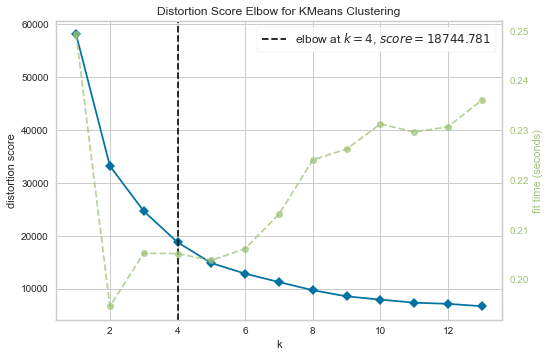

In [76]:
#Use elbow method to determine the optimum number of clusters needed 
kelbow_visualizer(KMeans(), rfm_df.iloc[:,4:7], k=(1,14));

In [77]:
kmeans1 = KMeans(n_clusters = 4,init = 'k-means++', random_state = 42)
kmeans1.fit(rfm_df.iloc[:,4:7])
centers = kmeans1.cluster_centers_

In [78]:
df = rfm_df.iloc[:,4:7] 
df.columns = df[['r_score', 'f_score', 'm_score']].columns
df['index_a'] = rfm_df.index
df['rfm_cluster'] = kmeans1.labels_

In [79]:
rfm_df['rfm_segment']= df['rfm_cluster'].copy()
rfm_df['rfm_cluster'] = df['rfm_cluster'].copy()
rfm_df['rfm_segment'] = rfm_df['rfm_segment'].replace([0,1,2,3], ['High value','New Customer',
                                                                  'Best Customer','Low Value Customer'])

In [80]:
rfm_df.groupby('rfm_segment').agg({
    'Recency': ['count','mean', 'median','min','max'],
    'Frequency': ['count','mean', 'median','min', 'max'],
    'Monetary': ['count','mean', 'median','min', 'max']
})

Recency                          Frequency             \
                     count      mean median min max     count       mean   
rfm_segment                                                                
Best Customer         2834  4.617502      4   2  18      2834  10.261468   
High value            4737  0.820562      1   0   2      4737  13.147351   
Low Value Customer    3104  0.932023      1   0   2      3104   5.352771   
New Customer          3817  6.746660      6   3  29      3817   4.187058   

                                  Monetary                              \
                   median min max    count        mean   median    min   
rfm_segment                                                              
Best Customer           9   2  29     2834  182.969012  155.475  18.91   
High value             12   6  36     4737  178.605651  159.380  15.29   
Low Value Customer      5   1  11     3104   63.117152   42.470   0.47   
New Customer            4   1  11     3817   45.700186   31.650   0.15   

                             
                        max  
rfm_segment                  
Best Customer       1327.74  
High value          1608.69  
Low Value Customer  1153.11  
New Customer         161.32

In [81]:
rfm_df.head()

,customer_id,Recency,Frequency,Monetary,r_score,f_score,m_score,rfm_segment,rfm_cluster
6887,79d9d4f86aca4bed9290350fb43817c2,0,36,173.41,4,4,4,High value,0
8472,94de646f7b6041228ca7dec82adb97d2,0,35,90.23,4,4,3,High value,0
9377,a42ed50acc4d4b25bca647c9e0b916ad,0,31,461.09,4,4,4,High value,0
9774,ab25fd6fbd5040f880751921e4029757,0,30,717.21,4,4,4,High value,0
11825,d0a80415b84c4df4908b8403b19765e3,0,30,260.69,4,4,4,High value,0


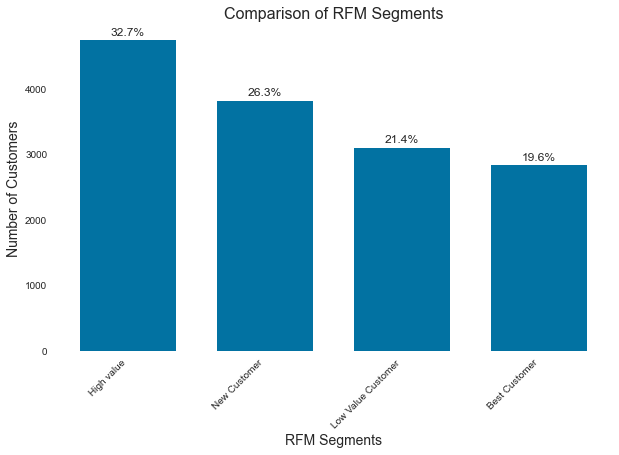

In [82]:
import matplotlib.pyplot as plt
import numpy as np

segment_counts = rfm_df['rfm_segment'].value_counts()

fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(segment_counts))
bar_width = 0.7

bars = ax.bar(x, segment_counts.values, width=bar_width)

ax.set_title('Comparison of RFM Segments', fontsize=16)
ax.set_xlabel('RFM Segments', fontsize=14)
ax.set_ylabel('Number of Customers', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(segment_counts.index, rotation=45, ha="right")
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Display percentage values on top of the bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height / segment_counts.sum() * 100:.1f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=12)
plt.grid(False)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()


In [83]:
rfm_analysis = pd.merge(profile_offer, rfm_df, left_on='customer_id', right_on='customer_id', how='inner')

In [84]:
rfm_analysis.head()

,customer_id,gender,age,age_group,customer_income,customer_income_range,became_member_on,year_joined,gender_F,gender_M,...,web_viewed_rate,web_completed_rate,Recency,Frequency,Monetary,r_score,f_score,m_score,rfm_segment,rfm_cluster
0,0610b486422d4921ae7d2bf64640c50b,F,55,44-56,112000.0,>$100K,2017-07-15,2017,1,0,...,0.0,1.000000,7,3,77.01,1,1,2,New Customer,1
1,78afa995795e4d85b5d9ceeca43f5fef,F,75,57-75,100000.0,>$100K,2017-05-09,2017,1,0,...,1.0,1.000000,7,7,159.27,1,2,3,Best Customer,2
2,e2127556f4f64592b11af22de27a7932,M,68,57-75,70000.0,"$(50,000-74,999)",2018-04-26,2018,0,1,...,1.0,0.666667,8,3,57.73,1,1,2,New Customer,1
3,389bc3fa690240e798340f5a15918d5c,M,65,57-75,53000.0,"$(50,000-74,999)",2018-02-09,2018,0,1,...,1.0,0.833333,4,3,36.43,2,1,2,New Customer,1
4,2eeac8d8feae4a8cad5a6af0499a211d,M,58,57-75,51000.0,"$(50,000-74,999)",2017-11-11,2017,0,1,...,1.0,0.500000,6,4,15.62,1,1,1,New Customer,1


In [85]:
#Create dummy variables for the RFM segments
rfm_dummies = pd.get_dummies(rfm_analysis['rfm_segment'])
rfm_analysis = rfm_analysis.join(rfm_dummies)

In [86]:
rfm_segment= rfm_analysis[['customer_id','High value','New Customer','Best Customer','Low Value Customer']]

In [87]:
def plot_data(df,demo,groupby,col_wrap,height,label_rotation):
    
   
    
    #Aggrigate measure(sum) grouped by demographics 
    df = df.join(demo[groupby])
    df = df.copy().reset_index()
    df = df.melt(id_vars=['customer_id', groupby],ignore_index = True)
    df = df.groupby([groupby, 'variable']).mean().reset_index()
    df = df[df['variable']!='index']
  
   
   
    g = sns.FacetGrid(df, col='variable', hue= groupby, col_wrap=col_wrap, height=height, sharey=False)
    g = g.map(plt.bar, groupby, 'value').set_titles("{col_name}")
    g.set_xticklabels(rotation = label_rotation)
    g.tight_layout()
    
    

    #Return aggregate data grouped by demographic variable entered in 'groupby'
    return df



## Visualize RFM Segments 

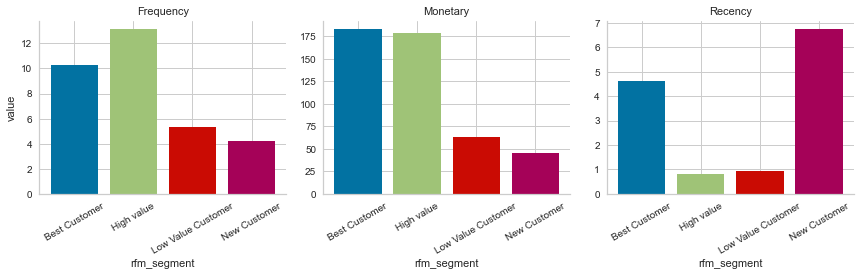

In [88]:
#Visualize the mean Frequency, Monetary, and Recency value across each RFM segments

rfm_da= rfm_df[['customer_id','Recency','Frequency','Monetary']]
df = plot_data(rfm_da,rfm_df,  groupby = 'rfm_segment',col_wrap=5,height=4,label_rotation =30)

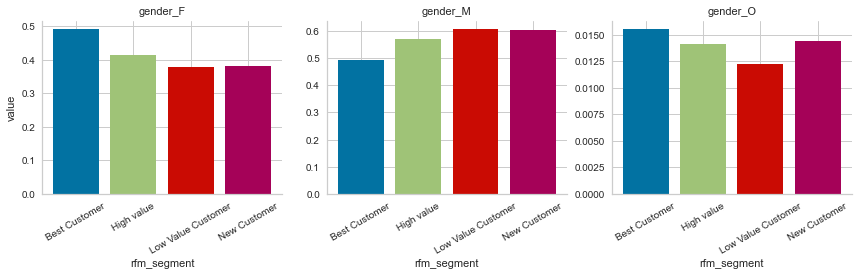

In [89]:
rfm_gender = rfm_analysis[['customer_id','gender_M','gender_F',"gender_O"]]
df = plot_data(rfm_gender,rfm_analysis,  groupby = 'rfm_segment',col_wrap=5,height=4,label_rotation =30)

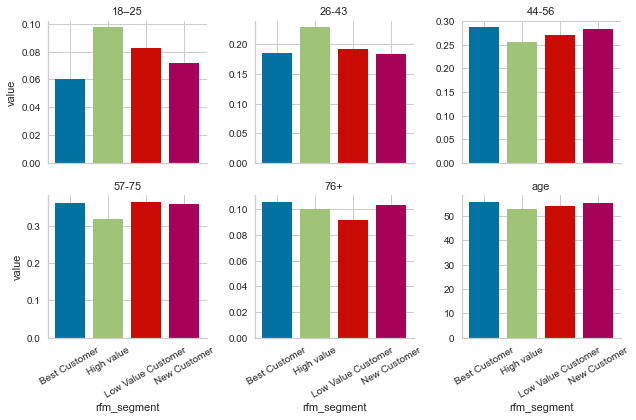

In [90]:
rfm_age= rfm_analysis[['customer_id', 'age','18–25','26-43','44-56','57-75','76+']]
df = plot_data(rfm_age,rfm_analysis,  groupby = 'rfm_segment',col_wrap=3,height=3,label_rotation =30)

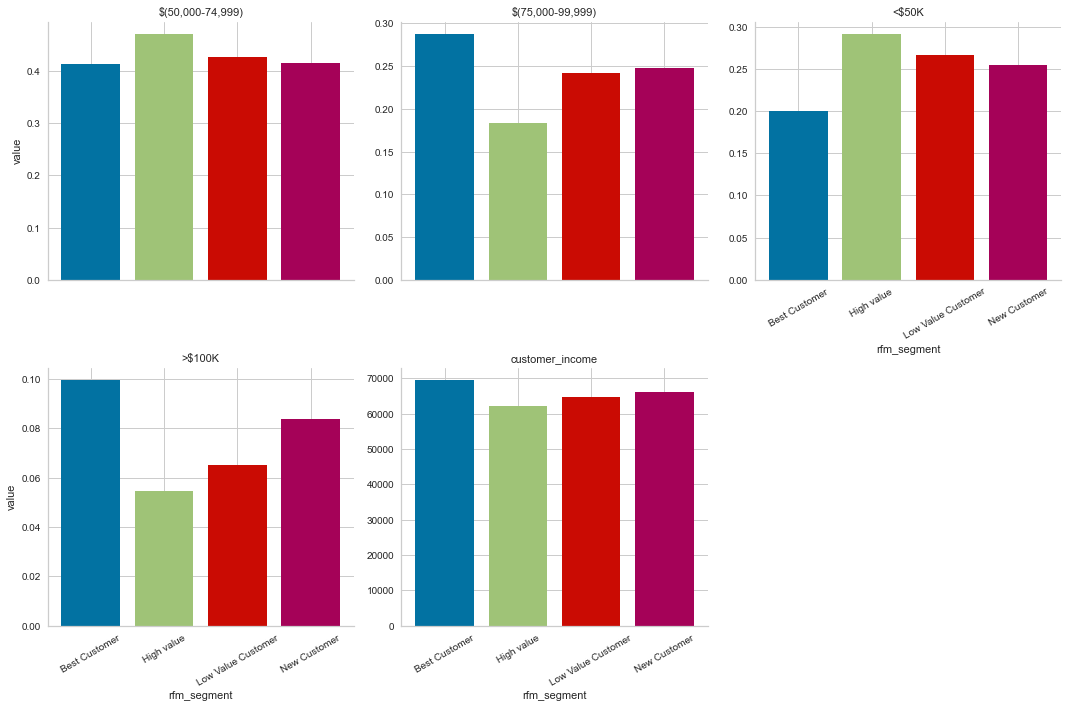

In [91]:
rfm_income_range = rfm_analysis[['customer_id','customer_income', '<$50K','$(50,000-74,999)','$(75,000-99,999)', '>$100K']]
df = plot_data(rfm_income_range,rfm_analysis,  groupby = 'rfm_segment',col_wrap=3,height=5,label_rotation =30)

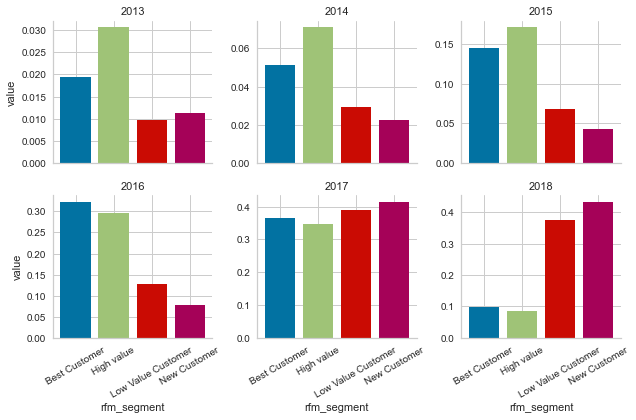

In [92]:
rfm_year = rfm_analysis[['customer_id',2013, 2014, 2015, 2016, 2017, 2018]]
df = plot_data(rfm_year,rfm_analysis,  groupby = 'rfm_segment',col_wrap=3,height=3,label_rotation =30)

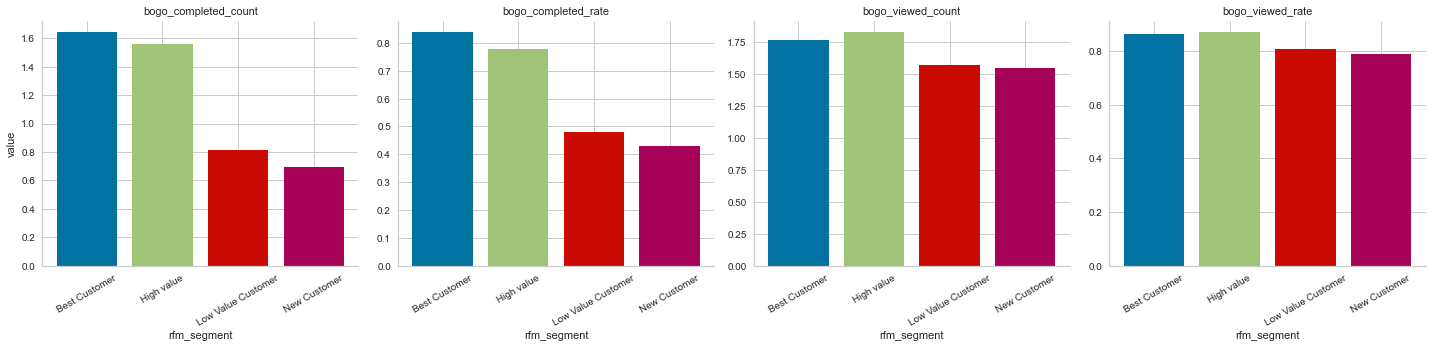

In [93]:
offer_bogo = rfm_analysis[['customer_id','bogo_viewed_count','bogo_completed_count','bogo_viewed_rate','bogo_completed_rate']]
df = plot_data(offer_bogo,rfm_analysis,  groupby = 'rfm_segment',col_wrap=5,height=5,label_rotation =30)

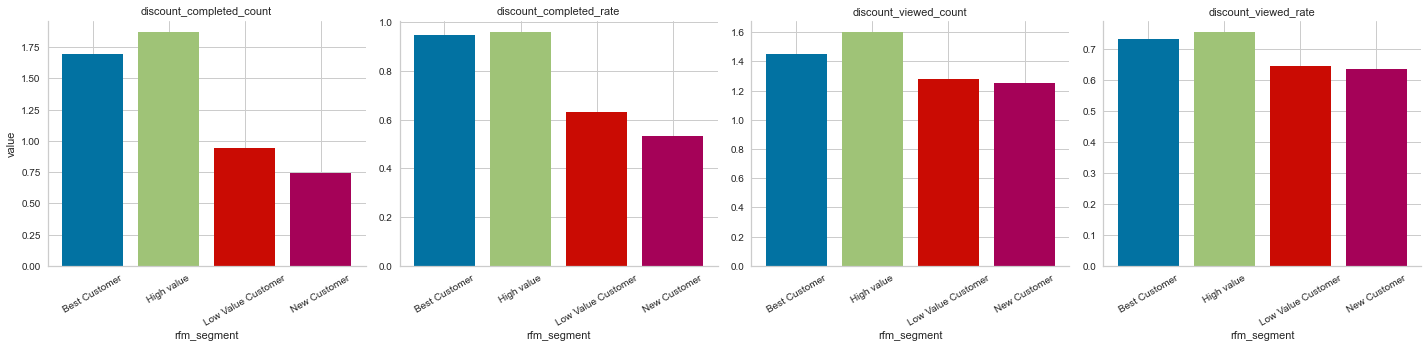

In [94]:
offer_discount = rfm_analysis[['customer_id','discount_viewed_count','discount_completed_count','discount_viewed_rate','discount_completed_rate']]
df = plot_data( offer_discount,rfm_analysis,  groupby = 'rfm_segment',col_wrap=4,height=5,label_rotation =30)

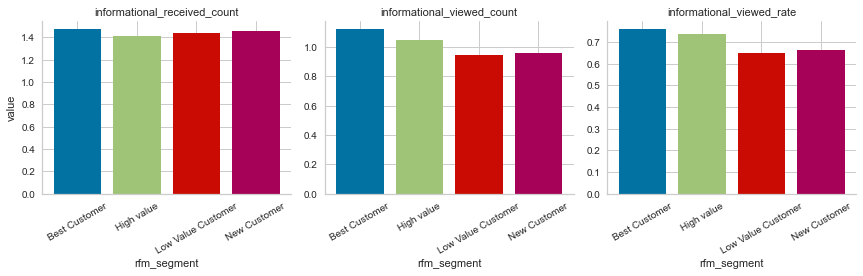

In [95]:
offer_informational = rfm_analysis[['customer_id','informational_received_count','informational_viewed_count','informational_viewed_rate']]
df = plot_data(offer_informational,rfm_analysis,  groupby = 'rfm_segment',col_wrap=5,height=4,label_rotation =30)

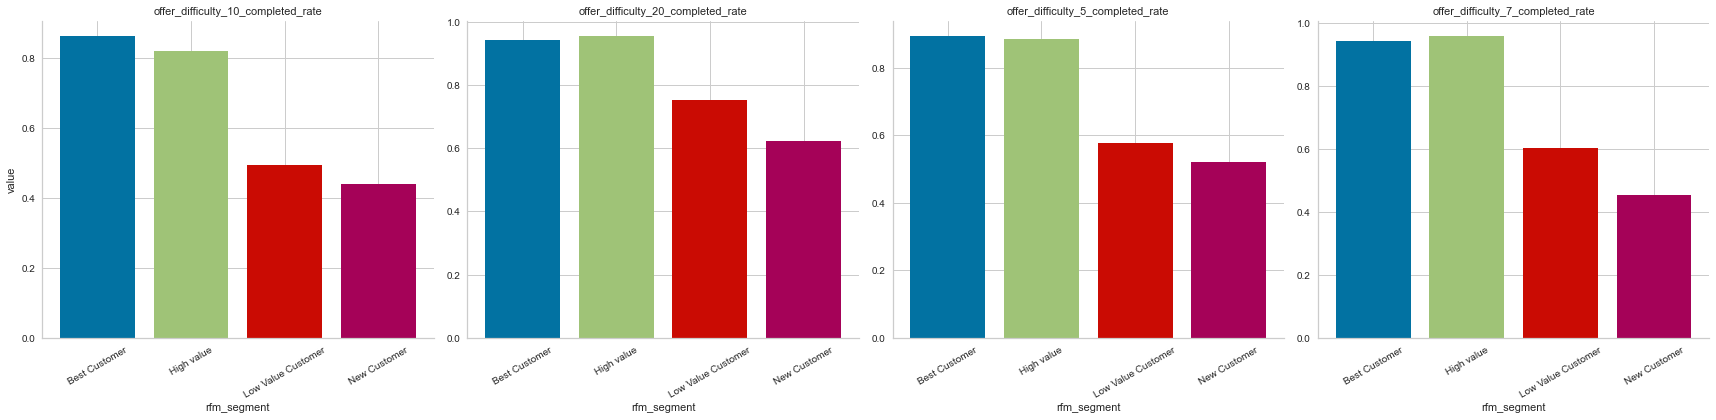

In [96]:
offer_difficulty =  rfm_analysis[['customer_id','offer_difficulty_5_completed_rate',
 'offer_difficulty_20_completed_rate','offer_difficulty_10_completed_rate', 'offer_difficulty_7_completed_rate']]
df = plot_data(offer_difficulty ,rfm_analysis,   groupby = 'rfm_segment',col_wrap=4,height=6,label_rotation =30)

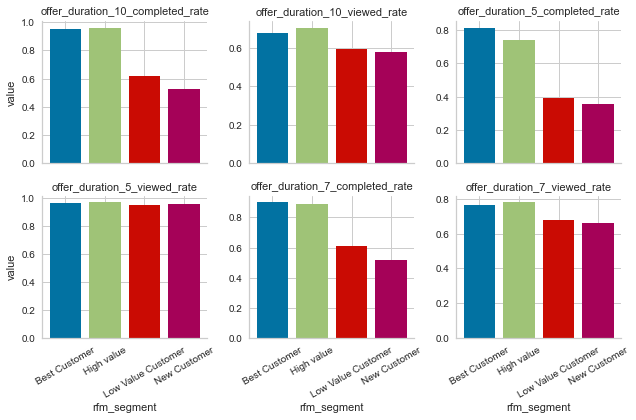

In [97]:
offer_duration =  rfm_analysis[['customer_id', 'offer_duration_7_viewed_rate', 'offer_duration_7_completed_rate',
 'offer_duration_10_viewed_rate', 'offer_duration_10_completed_rate','offer_duration_5_viewed_rate',
 'offer_duration_5_completed_rate']]
df = plot_data(offer_duration ,rfm_analysis,  groupby = 'rfm_segment',col_wrap=3,height=3,label_rotation =30)

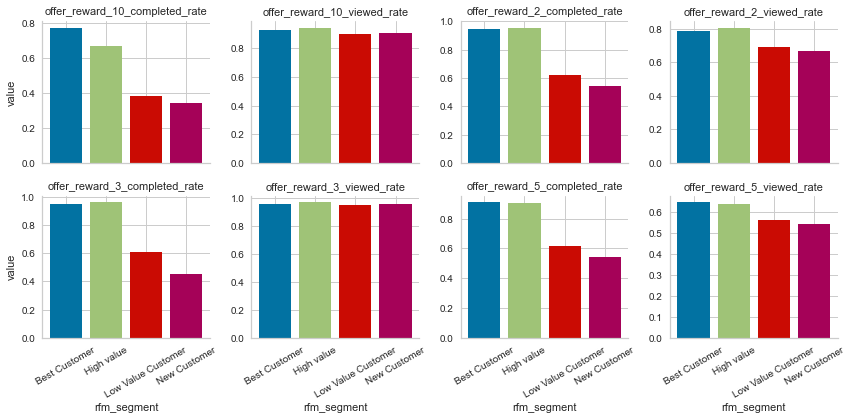

In [98]:
offer_reward =  rfm_analysis[['customer_id','offer_reward_2_viewed_rate','offer_reward_2_completed_rate',
 'offer_reward_3_viewed_rate','offer_reward_3_completed_rate','offer_reward_5_viewed_rate',
 'offer_reward_5_completed_rate','offer_reward_10_viewed_rate','offer_reward_10_completed_rate']]

df = plot_data(offer_reward ,rfm_analysis,   groupby = 'rfm_segment',col_wrap=4,height=3,label_rotation =30)


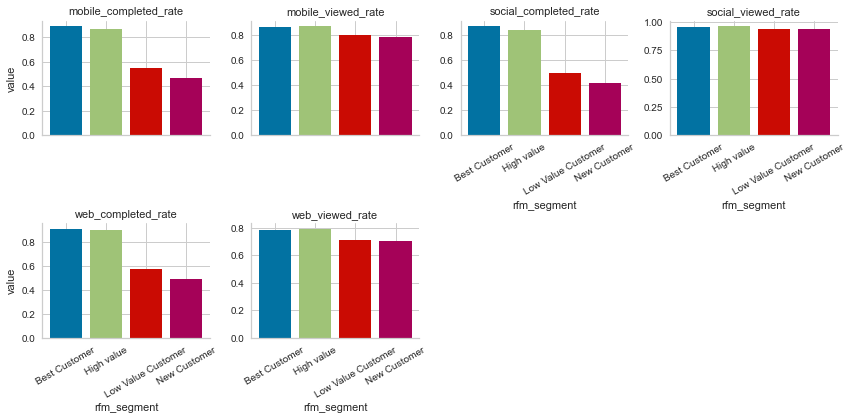

In [99]:
channel_completed =  rfm_analysis[['customer_id', 'mobile_completed_rate', 'social_completed_rate',
 'web_completed_rate','mobile_viewed_rate','social_viewed_rate', 'web_viewed_rate']]
df = plot_data(channel_completed ,rfm_analysis,  groupby = 'rfm_segment',col_wrap=4,height=3,label_rotation =30)

## RFM Segment 1: Best Customer

This segment consists of frequent customers who engage in substantial spending and have made recent purchases.

In terms of gender, age, and income distribution, this segment mirrors the overall sample.
While their average income is slightly lower than other segments, it remains considerable.
A significant number of customers in this segment joined the app during 2016 and 2017, with the highest concentration joining between 2013 and 2015.
Notably, this segment boasts the highest proportion of individuals belonging to Generation Z and Millennials.

Offers yield remarkable results with this group, exhibiting high view and completion rates across various offer characteristics such as categories, difficulty levels, durations, and rewards.

## RFM Segment 2: High Value

In this segment, you'll find customers who are frequent spenders, although it has been a significant duration since their last transaction.


The age and income distribution of this segment aligns with the overall sample.
An almost equal number of male and female customers are present. Additionally, this segment showcases the highest proportion of females and those identifying as 'Others' compared to other segments.
While the average age is comparable to other segments, it's noteworthy that this group has the highest proportion of individuals falling into the GenX category and the least proportion of GenZ customers.
This segment boasts the highest average income among all segments. Furthermore, it has the largest representation of individuals earning above 75k and the least representation of those earning under $50k.
Most of the customers in this segment joined the app during 2016 and 2017, with the majority joining in 2016.

Overall, offers show solid performance within this segment, closely rivaling the performance in the 'Best Customers' segment.
Particularly notable is their slightly superior performance in areas such as BOGO offers, offers with a difficulty level of 10, a duration of 5, and a reward of 10.

## RFM Segment 3: Lost Customer

This segment comprises customers who infrequently make purchases, spend minimally, and haven't engaged in recent transactions.

Gender, age, and income distribution aligns with the overall sample.
Notably, there is a significantly higher representation of males and a lower representation of females within this segment compared to the overall sample.
This segment encompasses a relatively high proportion of individuals categorized as Boomers and Matures.
Interestingly, a substantial proportion of high-income customers are part of this segment.
The majority of customers in this segment joined the app between 2017 and 2018, with the smallest portion having joined between 2013 and 2016.

As anticipated, this segment demonstrates inferior performance across all offer categories.
While customers in this segment tend to view a substantial number of the offers sent to them, the conversion rates for these offers remain notably lower.

## RFM Segment 4: New Customers

Within this segment, you'll find customers who are recent shoppers, displaying a low frequency of purchases and smaller transaction amounts.

Gender, age, and income distribution align with the overall sample.
This segment includes the highest proportion of male customers and the lowest proportion of females within the entire sample.
A notable characteristic of this segment is the highest representation of individuals earning less than 50k.
The majority of customers in this segment joined the app during 2017 and 2018.

Due to their recent arrival, new customers exhibit relatively modest offer performance.
Nevertheless, their performance consistently surpasses that of the Low Value segment.